In [94]:
import sys

path_up = ".."
if not path_up in sys.path:
    sys.path.append(path_up)

In [95]:
import datetime
import os
import re

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import yfinance as yf
from matplotlib import dates as mdates

from funcs.ios import get_excel_sheet
from structs.res import AppRes

In [96]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()

### 今日（作成日）の日付文字列

In [121]:
dt_today = datetime.datetime.now()
today_str = f"{dt_today.year:4d}{dt_today.month:02d}{dt_today.day:02d}"
today_str

'20251104'

In [97]:
res = AppRes()
file = "ticks_20250819.xlsx"
path_excel = os.path.join("..", res.dir_collection, file)
code = "7011"
df = get_excel_sheet(path_excel, code)
df.index = pd.to_datetime([datetime.datetime.fromtimestamp(ts) for ts in df["Time"]])
df

,Time,Price,Volume
2025-08-19 09:01:17.689856,1.755562e+09,4036,1826100
2025-08-19 09:01:18.692876,1.755562e+09,4036,1826100
2025-08-19 09:01:19.675019,1.755562e+09,4031,1879100
2025-08-19 09:01:20.672993,1.755562e+09,4031,1879100
2025-08-19 09:01:21.687569,1.755562e+09,4030,1895200
...,...,...,...
2025-08-19 15:24:55.392636,1.755585e+09,3913,25373500
2025-08-19 15:24:56.383619,1.755585e+09,3913,25373500
2025-08-19 15:24:57.386104,1.755585e+09,3915,25377000
2025-08-19 15:24:58.392595,1.755585e+09,3915,25377000


## 株価そのまま

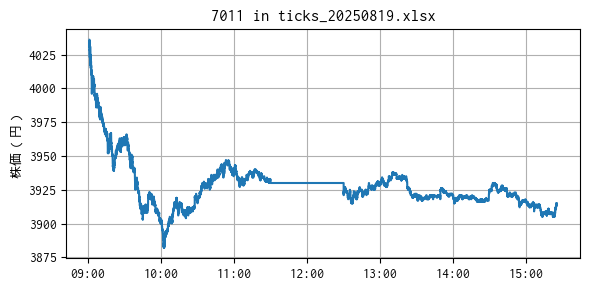

In [98]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df["Price"])
ax.xaxis.set_major_formatter(mdates.DateFormatter("%H:%M"))
ax.set_ylabel("株価（円）")
ax.grid()
ax.set_title(f"{code} in {file}")
plt.tight_layout()
plt.show()

In [99]:
# 前日のOHLC
def get_last_ohlc(file: str, code: str) -> pd.DataFrame:
    pattern = re.compile(r"ticks_(\d{4})(\d{2})(\d{2})\.xlsx")
    if m := pattern.match(file):
        yr = m.group(1)
        mo = m.group(2)
        dy = m.group(3)
    else:
        yr = "1970"
        mo = "01"
        dy = "01"
    date_end = f"{yr}-{mo}-{dy}"
    ticker = yf.Ticker(f"{code}.T")
    return ticker.history(period="10d", interval="1d", end=date_end).tail(1)

## 当日の始値で株価を割った場合

In [101]:
df_summary_1 = pd.DataFrame(
    {
        "file": [],
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "range": [],
    }
)
code = "7011"
files = sorted(os.listdir(os.path.join("..", res.dir_collection)))
for file in files:
    path_excel = os.path.join("..", res.dir_collection, file)
    code = "7011"
    df = get_excel_sheet(path_excel, code)
    df.index = pd.to_datetime(
        [datetime.datetime.fromtimestamp(ts) for ts in df["Time"]]
    )
    price_open = df.iloc[0]["Price"]

    df["PriceRatio"] = (df["Price"] / price_open) - 1
    r = len(df_summary_1)
    df_summary_1.loc[r] = [
        file,
        df["PriceRatio"].mean(),
        df["PriceRatio"].std(),
        df["PriceRatio"].min(),
        df["PriceRatio"].max(),
        df["PriceRatio"].max() - df["PriceRatio"].min(),
    ]
df_summary_1

,file,mean,std,min,max,range
0,ticks_20250819.xlsx,-0.026932,0.004673,-0.038157,0.000000,0.038157
1,ticks_20250820.xlsx,-0.000019,0.002967,-0.012304,0.007068,0.019372
2,ticks_20250821.xlsx,-0.005019,0.002935,-0.011752,0.008618,0.020371
3,ticks_20250822.xlsx,-0.000948,0.003729,-0.006776,0.006776,0.013552
4,ticks_20250825.xlsx,-0.016042,0.002468,-0.019360,0.000000,0.019360
5,ticks_20250826.xlsx,-0.010741,0.004273,-0.015187,0.003928,0.019115
6,ticks_20250827.xlsx,-0.006208,0.002799,-0.011352,0.004752,0.016103
7,ticks_20250828.xlsx,0.014265,0.005026,-0.006972,0.020649,0.027621
8,ticks_20250829.xlsx,-0.003155,0.003439,-0.008203,0.007939,0.016142
9,ticks_20250901.xlsx,0.008446,0.009511,-0.003227,0.034418,0.037645


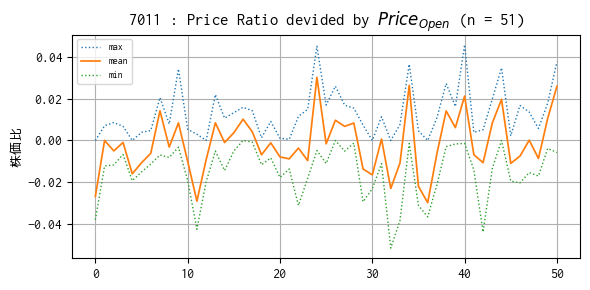

In [139]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_summary_1["max"], linewidth=1, linestyle="dotted", label="max")
ax.plot(df_summary_1["mean"], linewidth=1.25, linestyle="solid", label="mean")
ax.plot(df_summary_1["min"], linewidth=1, linestyle="dotted", label="min")
ax.set_ylabel("株価比")
ax.grid()
ax.legend(fontsize=7)
ax.set_title(f"{code} : Price Ratio devided by ${{Price}}_{{Open}}$ (n = {len(df_summary_1)})")
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_trend_open.png"))
plt.show()

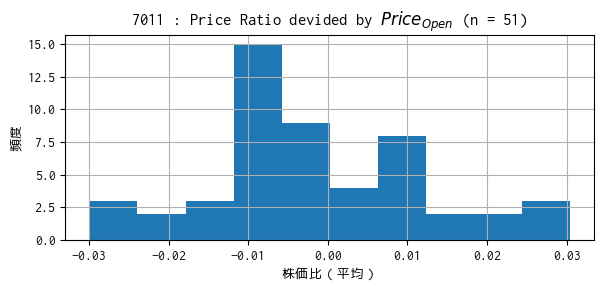

In [140]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_1["mean"])
ax.set_xlabel("株価比（平均）")
ax.set_ylabel("頻度")
ax.grid()
ax.set_title(f"{code} : Price Ratio devided by ${{Price}}_{{Open}}$ (n = {len(df_summary_1)})")
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_hist_mean_open.png"))
plt.show()

In [141]:
print(
    f"min: {df_summary_1["mean"].min():6.4f}, "
    f"mean: {df_summary_1["mean"].mean():6.4f}, "
    f"max: {df_summary_1["mean"].max():6.4f}"
)

min: -0.0300, mean: -0.0017, max: 0.0304


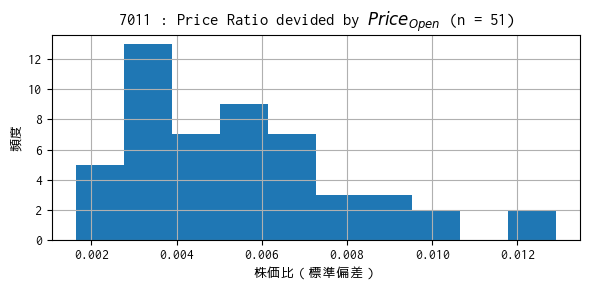

In [142]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_1["std"])
ax.set_xlabel("株価比（標準偏差）")
ax.set_ylabel("頻度")
ax.grid()
ax.set_title(f"{code} : Price Ratio devided by ${{Price}}_{{Open}}$ (n = {len(df_summary_1)})")
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_hist_std_open.png"))
plt.show()

## 前営業日の終値で株価を割った場合

In [143]:
df_summary_2 = pd.DataFrame(
    {
        "file": [],
        "lastday": [],
        "mean": [],
        "std": [],
        "min": [],
        "max": [],
        "range": [],
    }
)
code = "7011"
files = sorted(os.listdir(os.path.join("..", res.dir_collection)))
for file in files:
    path_excel = os.path.join("..", res.dir_collection, file)
    code = "7011"
    df = get_excel_sheet(path_excel, code)
    df.index = pd.to_datetime(
        [datetime.datetime.fromtimestamp(ts) for ts in df["Time"]]
    )
    price_open = df.iloc[0]["Price"]

    # 前日の終値
    df_last = get_last_ohlc(file, code)
    price_lastclose = df_last.iloc[0]["Close"]
    dt_last = df_last.index[-1]
    day_last = f"{dt_last.year:4d}-{dt_last.month:02d}-{dt_last.day:02d}"

    df["PriceRatio"] = (df["Price"] / price_lastclose) - 1
    r = len(df_summary_2)
    df_summary_2.loc[r] = [
        file,
        day_last,
        df["PriceRatio"].mean(),
        df["PriceRatio"].std(),
        df["PriceRatio"].min(),
        df["PriceRatio"].max(),
        df["PriceRatio"].max() - df["PriceRatio"].min(),
    ]
df_summary_2

,file,lastday,mean,std,min,max,range
0,ticks_20250819.xlsx,2025-08-18,-0.003402,0.004786,-0.014898,0.024182,0.039079
1,ticks_20250820.xlsx,2025-08-19,-0.018734,0.002912,-0.030789,-0.011780,0.019009
2,ticks_20250821.xlsx,2025-08-20,-0.000349,0.002949,-0.007114,0.013353,0.020466
3,ticks_20250822.xlsx,2025-08-21,0.010066,0.003770,0.004173,0.017875,0.013702
4,ticks_20250825.xlsx,2025-08-22,0.000718,0.002510,-0.002656,0.017033,0.019690
5,ticks_20250826.xlsx,2025-08-25,-0.004527,0.004300,-0.009001,0.010234,0.019235
6,ticks_20250827.xlsx,2025-08-26,0.003248,0.002826,-0.001944,0.014312,0.016257
7,ticks_20250828.xlsx,2025-08-27,0.009040,0.005000,-0.012088,0.015392,0.027479
8,ticks_20250829.xlsx,2025-08-28,-0.005833,0.003430,-0.010868,0.005231,0.016098
9,ticks_20250901.xlsx,2025-08-29,0.002427,0.009454,-0.009176,0.028244,0.037420


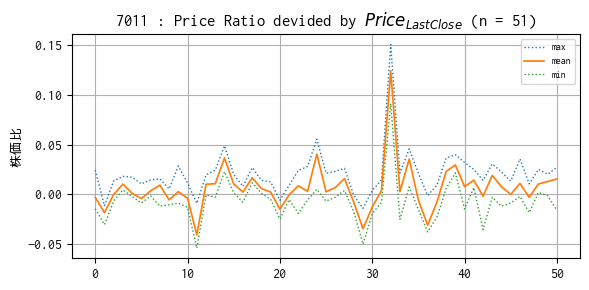

In [144]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.plot(df_summary_2["max"], linewidth=1, linestyle="dotted", label="max")
ax.plot(df_summary_2["mean"], linewidth=1.25, linestyle="solid", label="mean")
ax.plot(df_summary_2["min"], linewidth=1, linestyle="dotted", label="min")
ax.set_ylabel("株価比")
ax.grid()
ax.legend(fontsize=7)
ax.set_title(
    f"{code} : Price Ratio devided by ${{Price}}_{{LastClose}}$ (n = {len(df_summary_2)})"
)
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_trend_lastclose.png"))
plt.show()

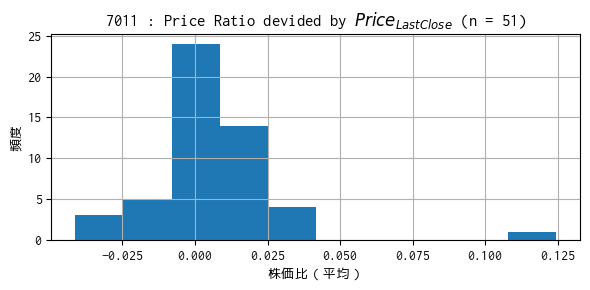

In [145]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_2["mean"])
ax.set_xlabel("株価比（平均）")
ax.set_ylabel("頻度")
ax.grid()
ax.set_title(
    f"{code} : Price Ratio devided by ${{Price}}_{{LastClose}}$ (n = {len(df_summary_2)})"
)
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_hist_mean_lastclose.png"))
plt.show()

In [146]:
print(
    f"min: {df_summary_2["mean"].min():6.4f}, "
    f"mean: {df_summary_2["mean"].mean():6.4f}, "
    f"max: {df_summary_2["mean"].max():6.4f}"
)

min: -0.0412, mean: 0.0060, max: 0.1244


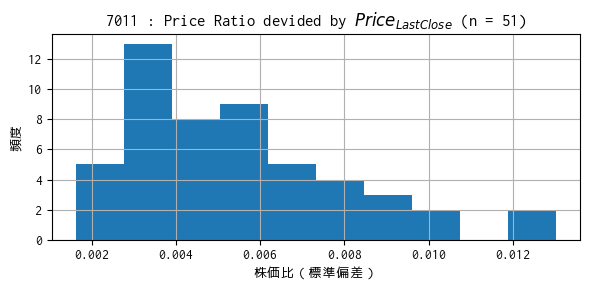

In [147]:
fig, ax = plt.subplots(figsize=(6, 3))
ax.hist(df_summary_2["std"])
ax.set_xlabel("株価比（標準偏差）")
ax.set_ylabel("頻度")
ax.grid()
ax.set_title(
    f"{code} : Price Ratio devided by ${{Price}}_{{LastClose}}$ (n = {len(df_summary_2)})"
)
plt.tight_layout()
plt.savefig(os.path.join("screenshots", f"{today_str}_{code}_priceratio_hist_std_lastclose.png"))
plt.show()